In [87]:
import pandas as pd

# Chargement du jeu de données
data = pd.read_csv("BenignAndMaliciousDataset.csv")


In [85]:
data = pd.read_csv("BenignAndMaliciousDataset.csv", dtype={'TLD': str, 'IpReputation': str})

In [ ]:
!find / -name "BenignAndMaliciousDataset.csv"

In [ ]:
import os

# Afficher le contenu du répertoire actuel
print(os.listdir())

In [ ]:
import os

# Parcourir les répertoires et sous-répertoires
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.csv'):  # Modifier l'extension selon le format de votre dataset
            print(os.path.join(root, file))

In [86]:
# Séparation des fonctionnalités et de la cible
X = data[['DNSRecordType', 'NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio', 'VowelRatio']]
y = data['Class']


In [88]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
import numpy as np

from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [89]:
#Avant l'encodage de l'attribut categroriciel

categorical_feature = X['DNSRecordType']

print(categorical_feature)


0        A
1        A
2        A
3        A
4        A
        ..
89995    A
89996    A
89997    A
89998    A
89999    A
Name: DNSRecordType, Length: 90000, dtype: object


In [90]:

# Définition de la taille du vocabulaire
vocab_size = 10000

# Création de la couche TextVectorization pour l'encodage des fonctionnalités textuelles
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=100)  # Taille fixe pour chaque séquence de fonctionnalités textuelles

# Adaptation de la couche TextVectorization aux données textuelles
dns_data = X['DNSRecordType'].astype(str)


vectorize_layer.adapt(dns_data)


In [91]:
# Données encodées et prétraitées
encoded_dns_data = np.array(vectorize_layer(dns_data))


In [92]:
#affichage de l'attribut apres vectorisation

print (encoded_dns_data)

[[2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


In [93]:
#avant l'encodage

numeric_features = ['NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio','VowelRatio']
print (data[numeric_features])

       NumericSequence  NumericRatio  StrangeCharacters  ConsoantRatio  \
0                    1           0.1                 11            0.6   
1                    2           0.1                 11            0.7   
2                    3           0.2                 24            0.6   
3                    2           0.1                 15            0.6   
4                    2           0.2                 23            0.6   
...                ...           ...                ...            ...   
89995                2           0.2                  3            0.5   
89996                0           0.0                  0            0.6   
89997                2           0.1                  1            0.5   
89998                0           0.0                  0            0.5   
89999                0           0.0                  1            0.6   

       VowelRatio  
0             0.2  
1             0.2  
2             0.2  
3             0.1  
4          

In [94]:
# Sélection des fonctionnalités numériques
numeric_features = X[['NumericSequence', 'NumericRatio', 'StrangeCharacters', 'ConsoantRatio','VowelRatio']]

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(numeric_features)

# Transformation des fonctionnalités numériques
scaled_numeric_features = scaler.transform(numeric_features)

In [95]:
# Apres transformation

# Création d' un DataFrame à partir des valeurs transformées
scaled_df = pd.DataFrame(scaled_numeric_features, columns=numeric_features.columns)

# Afficher le DataFrame avec les valeurs transformées
print("Après transformation")
print(scaled_df)

Après transformation
       NumericSequence  NumericRatio  StrangeCharacters  ConsoantRatio  \
0             0.022222         0.125           0.088710            0.6   
1             0.044444         0.125           0.088710            0.7   
2             0.066667         0.250           0.193548            0.6   
3             0.044444         0.125           0.120968            0.6   
4             0.044444         0.250           0.185484            0.6   
...                ...           ...                ...            ...   
89995         0.044444         0.250           0.024194            0.5   
89996         0.000000         0.000           0.000000            0.6   
89997         0.044444         0.125           0.008065            0.5   
89998         0.000000         0.000           0.000000            0.5   
89999         0.000000         0.000           0.008065            0.6   

       VowelRatio  
0           0.250  
1           0.250  
2           0.250  
3         

In [96]:
# Concaténation des données encodées et prétraitées
X_combined = np.concatenate([encoded_dns_data, scaled_numeric_features], axis=1)

In [97]:
#chargement de mon google dive pour stovker mon travail
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:

from keras.callbacks import ModelCheckpoint

In [99]:
#creation des chekpoint pour suivre l'historique de l'entrainement et sauvegarder le model le plus performant

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Models/meilleur_modele.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [100]:

# Création du modèle CNN
embedding_dim = 100

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=105),
    layers.Conv1D(32, 5, activation='relu'),
    layers.MaxPooling1D(5),
    layers.Conv1D(32, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [101]:
### Entraînement et évaluation du modèle

# Split des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


# Ajuster la forme des données d'entraînement je reshape a 105 car c'est la valeur definie dns moa couche d'embedding 
#est celle qui travailleras sur les données categoriques/textuelles

X_train = np.reshape(X_train, (X_train.shape[0], 105))

# Ajuster la forme des données de test
X_test = np.reshape(X_test, (X_test.shape[0], 105))


In [102]:
batch_size, dimension = X_train.shape[0], X_train.shape[1]
print("Batch size:", batch_size)
print("Dimension:", dimension)

#la dimension ici doit correspondre au maxlen de la couche embedding

Batch size: 72000
Dimension: 105


In [103]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/30
2250/2250 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9432
Epoch 1: val_loss improved from inf to 0.16630, saving model to /content/drive/MyDrive/Models/meilleur_modele.h5
2250/2250 [==============================] - 65s 28ms/step - loss: 0.1909 - accuracy: 0.9432 - val_loss: 0.1663 - val_accuracy: 0.9501
Epoch 2/30
   3/2250 [..............................] - ETA: 59s - loss: 0.2003 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2250/2250 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9496
Epoch 2: val_loss did not improve from 0.16630
2250/2250 [==============================] - 64s 28ms/step - loss: 0.1728 - accuracy: 0.9496 - val_loss: 0.1664 - val_accuracy: 0.9501
Epoch 3/30
2249/2250 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9495
Epoch 3: val_loss did not improve from 0.16630
2250/2250 [==============================] - 63s 28ms/step - loss: 0.1723 - accuracy: 0.9495 - val_loss: 0.1665 - val_accuracy: 0.9501
Epoch 4/30
2249/2250 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9496
Epoch 4: val_loss did not improve from 0.16630
2250/2250 [==============================] - 63s 28ms/step - loss: 0.1714 - accuracy: 0.9495 - val_loss: 0.1675 - val_accuracy: 0.9501
Epoch 5/30
2249/2250 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9496
Epoch 5: val_loss improved from 0.16630 to 0.16627, saving model to /cont

In [104]:
y_pred = model.predict(X_test)

print(y_pred)

563/563 [==============================] - 3s 5ms/step
[[0.08926634]
 [1.        ]
 [1.        ]
 ...
 [1.        ]
 [0.08926634]
 [1.        ]]


In [105]:
# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

In [106]:
# Évaluation des performances
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}, Loss: {loss}')

563/563 [==============================] - 3s 6ms/step - loss: 0.1663 - accuracy: 0.9501
Accuracy: 0.9500555396080017, Loss: 0.1662532091140747


In [107]:
#sauvegarde du model

model.save('model.h5')

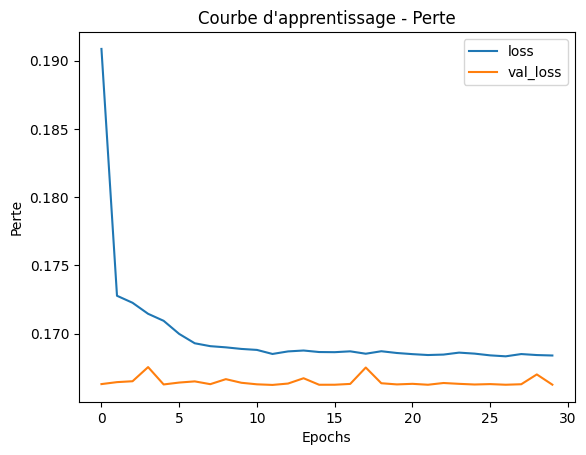

In [108]:
import matplotlib.pyplot as plt

# Plotter la courbe de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Courbe d\'apprentissage - Perte')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.show()


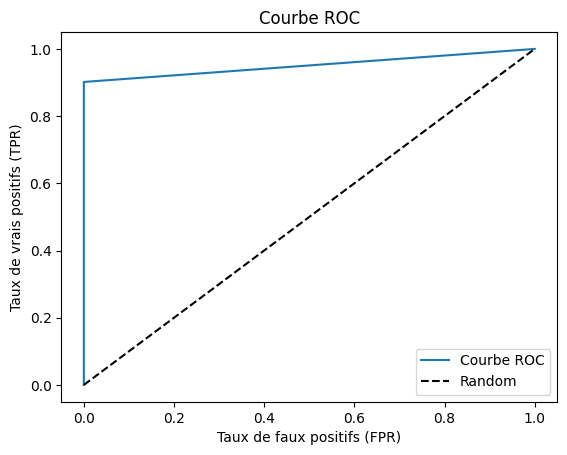

Aire sous la courbe (AUC) : 0.9508528318390553


In [110]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_pred)
print('Aire sous la courbe (AUC) :', auc)


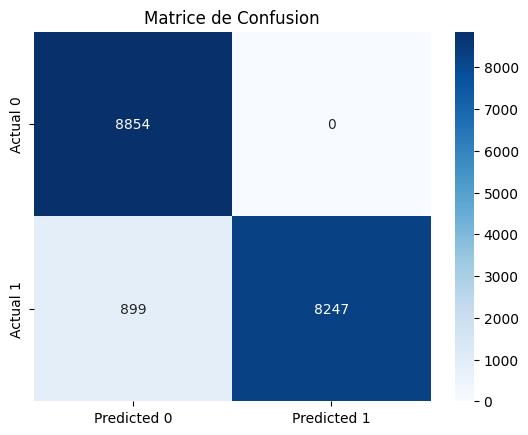

In [109]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix




#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(y_test,y_pred)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()


# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


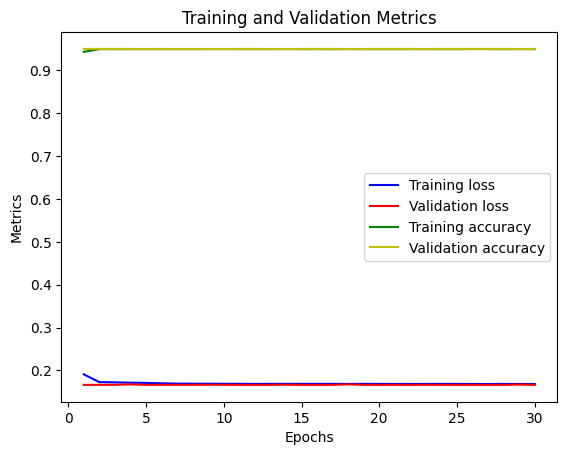

In [114]:
import matplotlib.pyplot as plt


# Récupérer les valeurs de loss, val_loss, accuracy et val_accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Afficher les courbes
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()